<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/GNN%20weighted%20GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from networkx.readwrite import write_graphml

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
def pyg_to_graphml(data, node_labels=None, output_file="graph.graphml"):
    """
    Convert PyTorch Geometric Data object to NetworkX graph and save as GraphML.

    Args:
        data: PyG Data object with edge_index, x, y, and optional edge_attr
        node_labels: List of node labels (strings)
        output_file: Output GraphML filename
    """
    # Create directed graph (use nx.Graph() for undirected)
    nx_graph = nx.DiGraph()

    # Add nodes with features, labels, and target values (y)
    for i in range(data.x.shape[0]):
        node_attrs = {}

        # Handle node features (x)
        features = data.x[i].tolist()
        if isinstance(features, list):
            if len(features) == 1:
                node_attrs["features"] = float(features[0])  # Single value as float
            else:
                # Convert multi-dimensional features to string
                node_attrs["features"] = ';'.join(map(str, features))  # CSV-like format
        else:
            node_attrs["features"] = float(features)

        # Add node labels if provided
        if node_labels is not None:
            node_attrs["label"] = str(node_labels[i])

        # Add target values (y) if they exist
        if hasattr(data, 'y') and data.y is not None:
            if data.y.dim() == 0:  # Single graph label
                if i == 0:  # Only add once for graph-level label
                    nx_graph.graph["graph_label"] = int(data.y.item())
            else:  # Node-level labels
                node_attrs["target"] = int(data.y[i].item())

        nx_graph.add_node(i, **node_attrs)

    # Add edges with weights if available
    for i in range(data.edge_index.shape[1]):
        source, target = data.edge_index[:,i]
        edge_attrs = {}
        if hasattr(data, 'edge_attr') and data.edge_attr is not None:
            edge_attrs["weight"] = float(data.edge_attr[i].item())
        nx_graph.add_edge(source.item(), target.item(), **edge_attrs)

    # Save as GraphML
    write_graphml(nx_graph, output_file)
    print(f"Graph saved to {output_file}")

# Example usage with all possible attributes
edge_index = torch.tensor([[0, 1, 1, 2, 3], [1, 0, 2, 1, 1]], dtype=torch.long)
edge_weights = torch.tensor([0.5, 0.3, 1.2, 0.8, 0.4], dtype=torch.float)
x = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float)
y = torch.tensor([1, 0, 2, 1], dtype=torch.long)  # Node-level targets
node_labels = ["Node A", "Node B", "Node C", "Node D"]

# Create Data object with all attributes
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights, y=y)

# Save to GraphML
pyg_to_graphml(data, node_labels=node_labels, output_file="complete_graph.graphml")

Graph saved to complete_graph.graphml


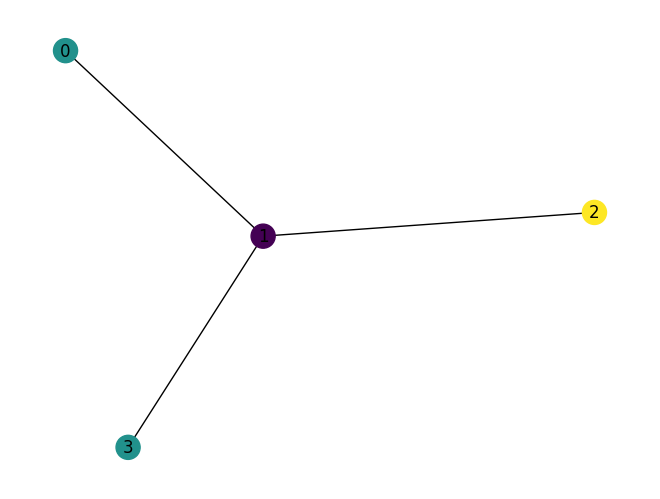

In [4]:
G = to_networkx(data, to_undirected=True)

pos = nx.spring_layout(G) # Layout of the graph
nx.draw(G, pos, with_labels=True, node_color=data.y.numpy())

# Karate Club Example

In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


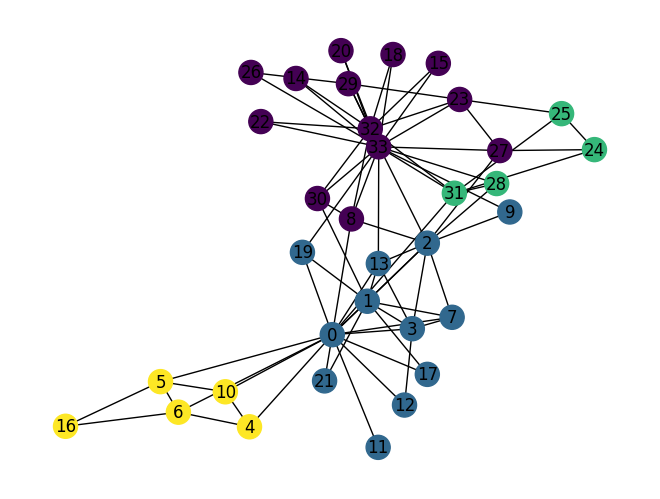

In [6]:
G = to_networkx(data, to_undirected=True)

pos = nx.spring_layout(G) # Layout of the graph
nx.draw(G, pos, with_labels=True, node_color=data.y.numpy())


In [7]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [8]:
node_labels = data.y.numpy()

In [9]:
pyg_to_graphml(data, node_labels = node_labels, output_file="karate_graph.graphml")


Graph saved to karate_graph.graphml


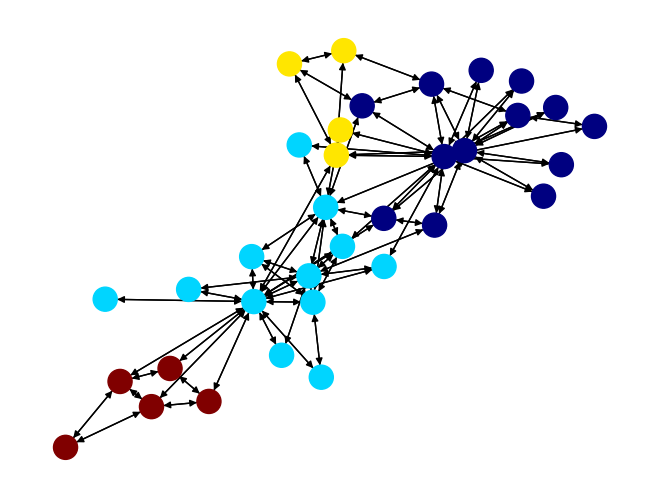

In [13]:
g = nx.read_graphml('karate_graph.graphml')

node_color = np.array(list(nx.get_node_attributes(g, 'label').values()), dtype=int)

plt.figure()
nx.draw(g, cmap=plt.get_cmap('jet'),
    node_color=node_color)
plt.show()

# PyTorch Graph data format

In [14]:
import torch
from torch_geometric.data import Data

In [15]:
import torch
from torch_geometric.data import Data

# Example weighted graph (edge list representation)
edges = [(0, 1, 1.0), (1, 2, 2.0), (2, 0, 3.0), (1, 0, 1.5)]

# Extract source, target, and weights
source_nodes = [edge[0] for edge in edges]
target_nodes = [edge[1] for edge in edges]
weights = [edge[2] for edge in edges]

# Create edge_index tensor
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

# Create edge_attr tensor for weights
edge_attr = torch.tensor(weights, dtype=torch.float)

# Example node features (3 nodes with 4 features each)
x = torch.tensor([
    [1.0, 2.0, 3.0, 4.0],  # Features for node 0
    [5.0, 6.0, 7.0, 8.0],  # Features for node 1
    [9.0, 10.0, 11.0, 12.0]  # Features for node 2
], dtype=torch.float)

# Classification labels for each node (3 nodes with class 0, 1, 2 respectively)
y = torch.tensor([0, 1, 2], dtype=torch.long)

# Create the Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

print(data)
print("\nNode features shape:", data.x.shape)
print("Edge index shape:", data.edge_index.shape)
print("Edge attributes shape:", data.edge_attr.shape)
print("Labels shape:", data.y.shape)

Data(x=[3, 4], edge_index=[2, 4], edge_attr=[4], y=[3])

Node features shape: torch.Size([3, 4])
Edge index shape: torch.Size([2, 4])
Edge attributes shape: torch.Size([4])
Labels shape: torch.Size([3])


In [18]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

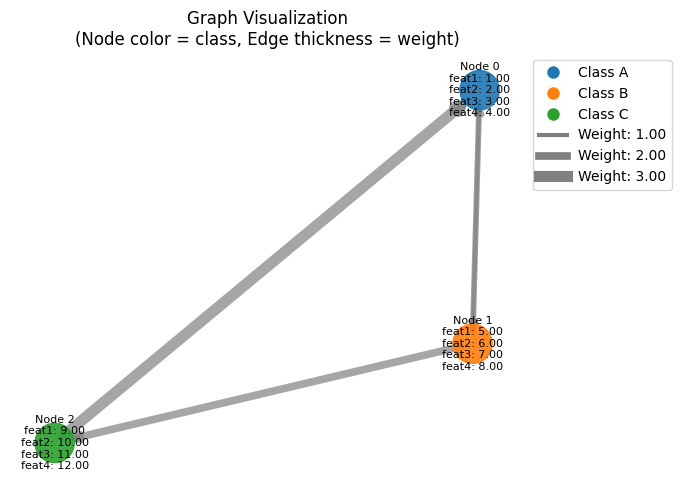

In [19]:
def visualize_graph(data, feature_names=None, class_names=None):
    """Visualize a PyG graph with features, labels, and edge weights.

    Args:
        data: PyTorch Geometric Data object
        feature_names: List of feature names (optional)
        class_names: List of class names (optional)
    """
    plt.figure(figsize=(7, 5))

    # Convert to networkx graph
    G = nx.DiGraph()

    # Add nodes with features and labels
    for i in range(data.x.shape[0]):
        G.add_node(i, features=data.x[i].numpy(), label=data.y[i].item())

    # Add edges with weights
    for src, dst, weight in zip(data.edge_index[0], data.edge_index[1], data.edge_attr):
        G.add_edge(src.item(), dst.item(), weight=weight.item())

    # Prepare colors for nodes based on labels
    unique_labels = list(set(data.y.numpy()))
    num_classes = len(unique_labels)
    cmap = ListedColormap(plt.cm.tab10.colors[:num_classes])

    # Node positions
    pos = nx.spring_layout(G, seed=42)

    # Draw edges with varying widths based on weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    min_weight, max_weight = min(edge_weights), max(edge_weights)
    edge_widths = [3 + 5 * (w - min_weight)/(max_weight - min_weight) for w in edge_weights]

    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7)

    # Draw nodes with colors based on labels
    node_colors = [G.nodes[n]['label'] for n in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                 cmap=cmap, node_size=800, alpha=0.9)

    # Draw node labels with feature vectors
    node_labels = {}
    for node in G.nodes():
        features = G.nodes[node]['features']
        if feature_names:
            features_str = '\n'.join([f'{name}: {val:.2f}' for name, val in zip(feature_names, features)])
        else:
            features_str = '\n'.join([f'{val:.2f}' for val in features])
        node_labels[node] = f"Node {node}\n{features_str}"

    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    # Create legends
    legend_elements = []

    # Class legend
    if class_names:
        for i, name in enumerate(class_names):
            legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                        label=name, markerfacecolor=cmap(i),
                                markersize=10))
    else:
        for i in unique_labels:
            legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                        label=f'Class {i}', markerfacecolor=cmap(i),
                                markersize=10))

    # Edge weight legend
    sample_weights = [min_weight, (min_weight + max_weight)/2, max_weight]
    for w in sample_weights:
        legend_elements.append(Line2D([0], [1], color='gray',
                                    linewidth=3 + 5 * (w - min_weight)/(max_weight - min_weight),
                                    label=f'Weight: {w:.2f}'))

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.title("Graph Visualization\n(Node color = class, Edge thickness = weight)")
    plt.tight_layout()
    plt.axis('off')
    plt.show()

# Example usage with your data
feature_names = ['feat1', 'feat2', 'feat3', 'feat4']  # Optional
class_names = ['Class A', 'Class B', 'Class C']        # Optional

visualize_graph(data, feature_names, class_names)

# Pandas DataFrame to Graph

In [41]:
import pandas as pd
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

In [42]:
# 1. First, include the dataframe_to_graph function from previous solution
def dataframe_to_graph(df_nodes, df_edges, node_id_col='node_id', label_col='label'):
    """Same function as before"""
    node_ids = df_nodes[node_id_col].unique()
    node_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(node_ids))}

    feature_cols = [col for col in df_nodes.columns
                   if col not in [node_id_col, label_col]]

    x = torch.tensor(
        df_nodes.sort_values(node_id_col)[feature_cols].values,
        dtype=torch.float
    )
    y = torch.tensor(
        df_nodes.sort_values(node_id_col)[label_col].values,
        dtype=torch.long
    )

    df_edges['source_mapped'] = df_edges['source'].map(node_id_map)
    df_edges['target_mapped'] = df_edges['target'].map(node_id_map)

    edge_index = torch.tensor(
        [df_edges['source_mapped'].values, df_edges['target_mapped'].values],
        dtype=torch.long
    )

    edge_attr = torch.tensor(
        df_edges['weight'].values.reshape(-1, 1),
        dtype=torch.float
    ) if 'weight' in df_edges.columns else None

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        num_nodes=len(node_ids)
    )


In [43]:
# 2. Then include the visualization function
def visualize_graph(data, feature_names=None, class_names=None):
    """Same visualization function as before"""
    plt.figure(figsize=(7, 5))
    G = nx.DiGraph()

    for i in range(data.x.shape[0]):
        G.add_node(i, features=data.x[i].numpy(), label=data.y[i].item())

    for src, dst, weight in zip(data.edge_index[0], data.edge_index[1], data.edge_attr):
        G.add_edge(src.item(), dst.item(), weight=weight.item())

    unique_labels = list(set(data.y.numpy()))
    num_classes = len(unique_labels)
    cmap = ListedColormap(plt.cm.tab10.colors[:num_classes])

    pos = nx.spring_layout(G, seed=42)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    min_weight, max_weight = min(edge_weights), max(edge_weights)
    edge_widths = [3 + 5 * (w - min_weight)/(max_weight - min_weight) for w in edge_weights]

    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7)
    node_colors = [G.nodes[n]['label'] for n in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                 cmap=cmap, node_size=800, alpha=0.9)

    node_labels = {}
    for node in G.nodes():
        features = G.nodes[node]['features']
        if feature_names:
            features_str = '\n'.join([f'{name}: {val:.2f}' for name, val in zip(feature_names, features)])
        else:
            features_str = '\n'.join([f'{val:.2f}' for val in features])
        node_labels[node] = f"Node {node}\n{features_str}"

    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    legend_elements = []
    if class_names:
        for i, name in enumerate(class_names):
            legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                        label=name, markerfacecolor=cmap(i),
                                markersize=10))
    else:
        for i in unique_labels:
            legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                        label=f'Class {i}', markerfacecolor=cmap(i),
                                markersize=10))

    sample_weights = [min_weight, (min_weight + max_weight)/2, max_weight]
    for w in sample_weights:
        legend_elements.append(Line2D([0], [1], color='gray',
                                    linewidth=3 + 5 * (w - min_weight)/(max_weight - min_weight),
                                    label=f'Weight: {w:.2f}'))

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.title("Graph Visualization\n(Node color = class, Edge thickness = weight)")
    plt.tight_layout()
    plt.axis('off')
    plt.show()


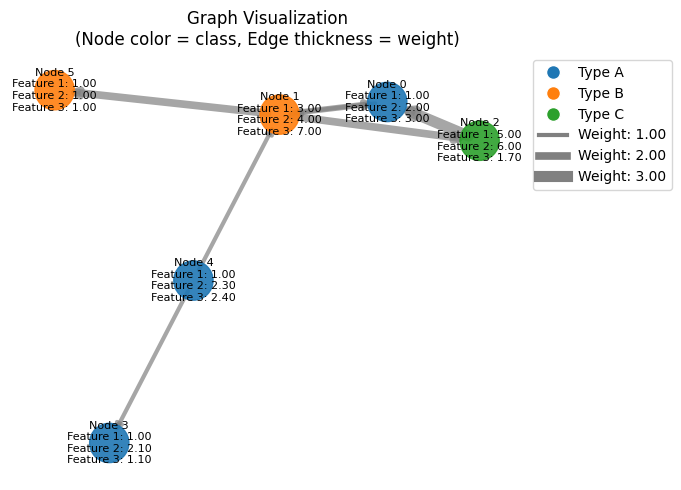

In [44]:

# 3. Example usage with DataFrames
# Create sample DataFrames
nodes_data = {
    'node_id': [100, 101, 102, 103, 104, 105],  # Original node IDs
    'feature1': [1.0, 3.0, 5.0, 1.0, 1.0, 1.0],
    'feature2': [2.0, 4.0, 6.0, 2.1, 2.3, 1.0],
    'feature3': [3.0, 7.0, 1.7, 1.1, 2.4, 1.0],
    'label': [0, 1, 2, 0, 0, 1]  # Class labels
}
df_nodes = pd.DataFrame(nodes_data)

edges_data = {
    'source': [100, 101, 102, 101, 104, 101, 104],  # Original node IDs
    'target': [101, 102, 100, 100, 103, 105, 101],
    'weight': [1.0, 2.0, 3.0, 1.5, 1.0, 2.0, 1.0]  # Edge weights
}
df_edges = pd.DataFrame(edges_data)

# Convert to graph
graph_data = dataframe_to_graph(
    df_nodes,
    df_edges,
    node_id_col='node_id',
    label_col='label'
)

# Visualize with feature names and class names
feature_names = ['Feature 1', 'Feature 2', 'Feature 3']
class_names = ['Type A', 'Type B', 'Type C']  # Optional descriptive names

visualize_graph(
    graph_data,
    feature_names=feature_names,
    class_names=class_names
)

# Weigthed Graph Neural Network

In the WeightedGCN class, node features and edge weights are processed during the graph convolutional operations.
Node features are stored in data.x (shape: [num_nodes, num_features])
At each layer:
Features are transformed by the weight matrix W in GCNConv
Neighbor features are aggregated based on edge weights
The output is a new set of node embeddings combining:
The node's own features
Weighted combination of neighbors' features

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

In [49]:


class WeightedGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(WeightedGCN, self).__init__()
        self.dropout = dropout
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(GCNConv(num_features, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))

        # Output layer
        self.layers.append(GCNConv(hidden_dim, num_classes))

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        # Normalize edge weights
        if edge_weight is not None:
            edge_weight = torch.sigmoid(edge_weight).view(-1)
            #Weights are normalized via sigmoid to (0,1) range
            #During message passing: stronger weights (→1) mean more influence from that neighbor
            # Weaker weights (→0) mean less influence
            #The weights scale how much neighbor features contribute to the target node's update

        # Apply GCN layers
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index, edge_weight=edge_weight)
            if i != len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        return F.log_softmax(x, dim=1)

class GCNNodeClassifier:
    def __init__(self, num_features, hidden_dim=64, num_classes=3, num_layers=2,
                 lr=0.01, weight_decay=5e-4, dropout=0.5, device='cpu'):
        self.device = torch.device(device)
        self.model = WeightedGCN(num_features, hidden_dim, num_classes,
                               num_layers, dropout).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                         lr=lr, weight_decay=weight_decay)
        self.criterion = nn.NLLLoss()

    def create_masks(self, num_nodes, train_ratio=0.6, val_ratio=0.2):
        """Create train/val/test masks for node classification"""
        indices = torch.arange(num_nodes)
        train_idx, test_idx = train_test_split(indices, train_size=train_ratio, random_state=42)
        val_idx, test_idx = train_test_split(test_idx, test_size=val_ratio/(1-train_ratio), random_state=42)

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)

        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True

        return train_mask, val_mask, test_mask

    def train(self, data, epochs=200, verbose=True):
        self.model.train()
        data = data.to(self.device)

        # Create masks if they don't exist
        if not hasattr(data, 'train_mask'):
            data.train_mask, data.val_mask, data.test_mask = self.create_masks(data.num_nodes)

        for epoch in range(epochs):
            self.optimizer.zero_grad()
            out = self.model(data)
            loss = self.criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            self.optimizer.step()

            if verbose and epoch % 50 == 0:
                val_acc = self.evaluate(data, data.val_mask)
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

    def evaluate(self, data, mask):
        self.model.eval()
        data = data.to(self.device)
        with torch.no_grad():
            out = self.model(data)
            pred = out.argmax(dim=1)
            correct = pred[mask] == data.y[mask]
            return correct.float().mean().item()

    def predict(self, data):
        self.model.eval()
        data = data.to(self.device)
        with torch.no_grad():
            out = self.model(data)
            return out.argmax(dim=1)


In [50]:
# Example usage with complete workflow
# 1. Create sample data
num_nodes = 100
num_features = 5
num_classes = 3

# Random features and labels
x = torch.randn((num_nodes, num_features))
y = torch.randint(0, num_classes, (num_nodes,))

# Random edges
edge_index = torch.randint(0, num_nodes, (2, 200))
edge_attr = torch.rand(200, 1) * 2  # Weights between 0-2

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

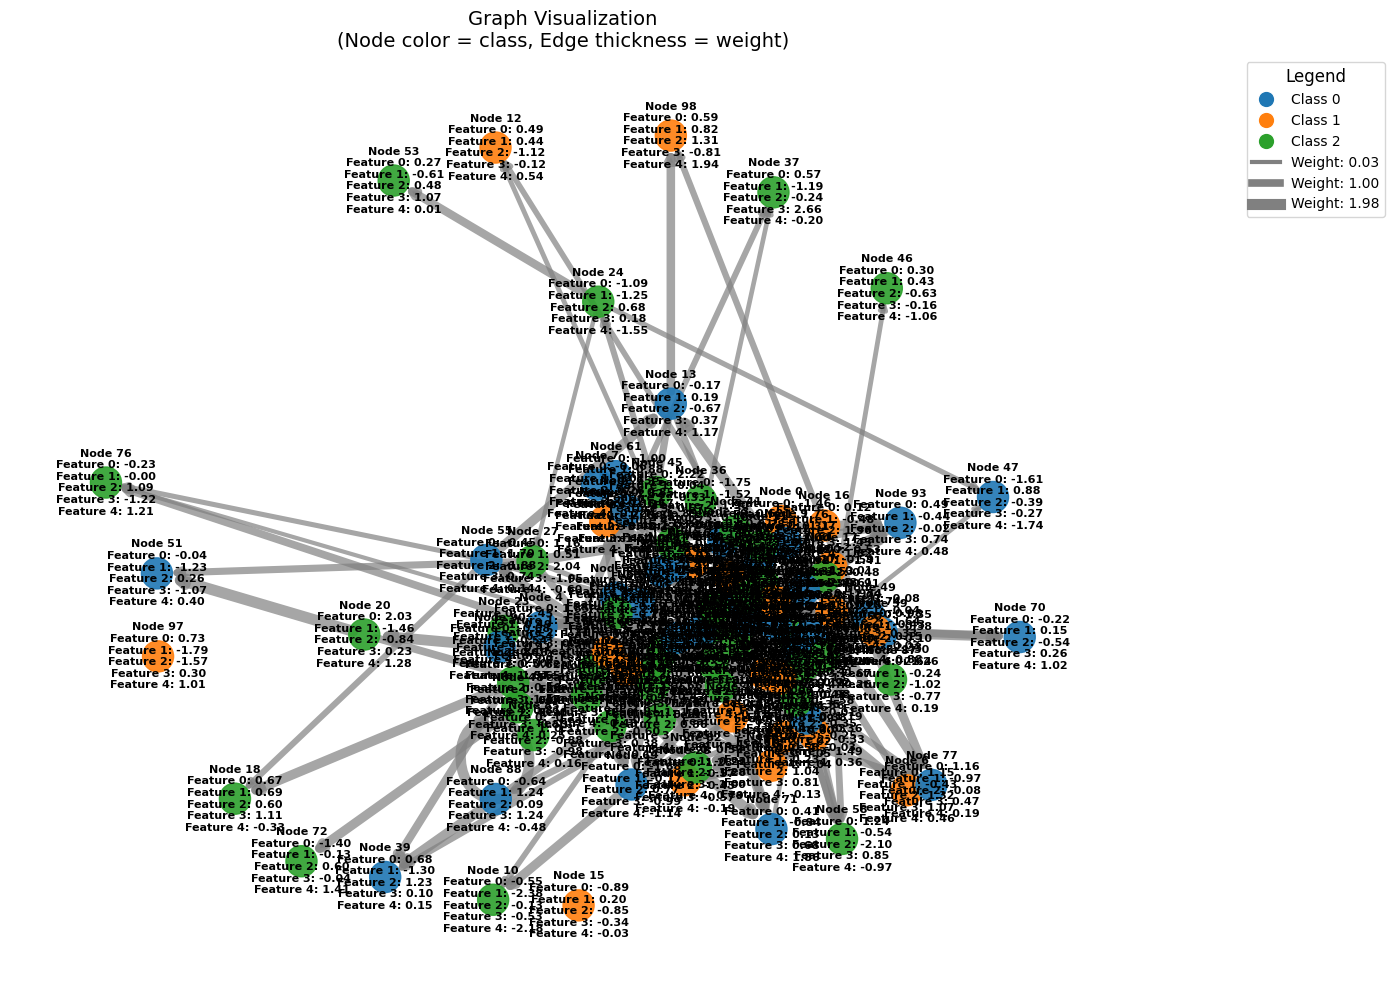

In [52]:
def visualize_graph(data, feature_names=None, class_names=None, node_size=800, figsize=(7, 5)):
    """
    Visualize a PyG graph with features, labels, and edge weights

    Args:
        data: PyG Data object with x, edge_index, edge_attr, y
        feature_names: List of feature names (optional)
        class_names: List of class names (optional)
        node_size: Size of nodes in visualization
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    G = nx.DiGraph()

    # Add nodes with features and labels
    for i in range(data.num_nodes):
        features = data.x[i].numpy() if i < data.x.shape[0] else [0]*data.x.shape[1]
        label = data.y[i].item() if hasattr(data, 'y') and i < len(data.y) else 0
        G.add_node(i, features=features, label=label)

    # Add edges with weights if they exist
    if hasattr(data, 'edge_index') and data.edge_index is not None:
        edge_weights = data.edge_attr.numpy().flatten() if hasattr(data, 'edge_attr') and data.edge_attr is not None else [1]*data.edge_index.shape[1]
        for src, dst, weight in zip(data.edge_index[0], data.edge_index[1], edge_weights):
            G.add_edge(src.item(), dst.item(), weight=weight)

    # Prepare colors for nodes based on labels
    unique_labels = list(set(G.nodes[n]['label'] for n in G.nodes()))
    num_classes = len(unique_labels)
    cmap = ListedColormap(plt.cm.tab10.colors[:num_classes])

    # Node positions using spring layout
    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

    # Draw edges with varying widths based on weights
    if G.edges():
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        min_weight, max_weight = min(edge_weights), max(edge_weights)
        edge_widths = [3 + 5 * (w - min_weight)/(max_weight - min_weight + 1e-5) for w in edge_weights]
        nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7, arrows=True)

    # Draw nodes with colors based on labels
    node_colors = [G.nodes[n]['label'] for n in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                 cmap=cmap, node_size=node_size, alpha=0.9)

    # Create node labels with feature vectors
    node_labels = {}
    for node in G.nodes():
        features = G.nodes[node]['features']
        if feature_names and len(feature_names) == len(features):
            features_str = '\n'.join([f'{name}: {val:.2f}' for name, val in zip(feature_names, features)])
        else:
            features_str = '\n'.join([f'f{i}: {val:.2f}' for i, val in enumerate(features)])
        node_labels[node] = f"Node {node}\n{features_str}"

    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold')

    # Create enhanced legend
    legend_elements = []
    if class_names and len(class_names) >= num_classes:
        for i, name in enumerate(class_names[:num_classes]):
            legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                      label=name, markerfacecolor=cmap(i),
                                      markersize=12))
    else:
        for i in unique_labels:
            legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                      label=f'Class {i}', markerfacecolor=cmap(i),
                                      markersize=12))

    if G.edges():
        sample_weights = [min_weight, (min_weight + max_weight)/2, max_weight]
        for w in sample_weights:
            legend_elements.append(Line2D([0], [1], color='gray',
                                        linewidth=3 + 5 * (w - min_weight)/(max_weight - min_weight + 1e-5),
                                        label=f'Weight: {w:.2f}'))

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1),
              fontsize=10, title="Legend", title_fontsize=12)

    plt.title("Graph Visualization\n(Node color = class, Edge thickness = weight)", fontsize=14)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

# Example usage with the previously created data
feature_names = [f'Feature {i}' for i in range(num_features)]
class_names = ['Class 0', 'Class 1', 'Class 2']

visualize_graph(
    data,
    feature_names=feature_names,
    class_names=class_names,
    node_size=500,
    figsize=(14, 10)
)

In [54]:
# 2. Initialize model
model = GCNNodeClassifier(
    num_features=num_features,
    hidden_dim=32,
    num_classes=num_classes,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# 3. Train the model
model.train(data, epochs=500)

# 4. Evaluate on test set
test_acc = model.evaluate(data, data.test_mask)
print(f'\nTest Accuracy: {test_acc:.4f}')

# 5. Make predictions
predictions = model.predict(data)
print(f'\nSample predictions: {predictions[:10]}')

Epoch: 000, Loss: 1.1198, Val Acc: 0.2500
Epoch: 050, Loss: 0.6876, Val Acc: 0.3500
Epoch: 100, Loss: 0.4371, Val Acc: 0.3000
Epoch: 150, Loss: 0.2531, Val Acc: 0.3000
Epoch: 200, Loss: 0.1514, Val Acc: 0.2500
Epoch: 250, Loss: 0.0978, Val Acc: 0.2500
Epoch: 300, Loss: 0.0698, Val Acc: 0.2500
Epoch: 350, Loss: 0.0553, Val Acc: 0.3000
Epoch: 400, Loss: 0.0473, Val Acc: 0.3000
Epoch: 450, Loss: 0.0430, Val Acc: 0.3000

Test Accuracy: 0.3500

Sample predictions: tensor([2, 0, 2, 2, 0, 0, 1, 0, 0, 1])


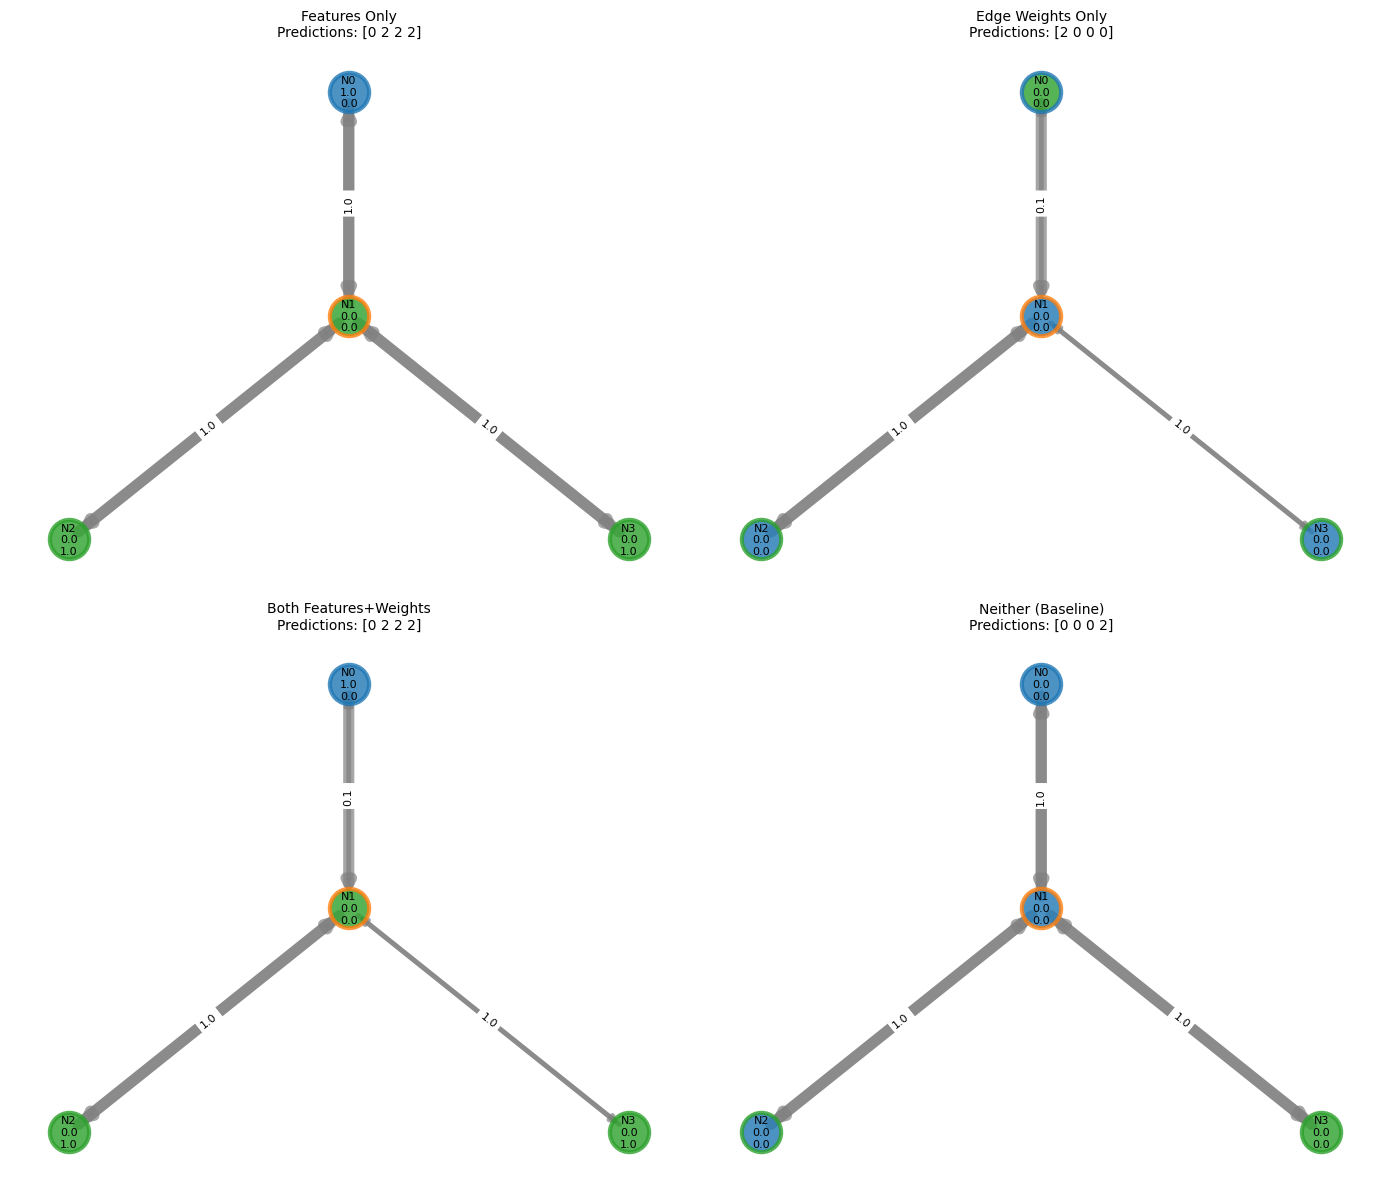

In [55]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def create_test_graph(feature_effect=True, edge_weight_effect=True):
    """Create a test graph where we can control which factors affect predictions"""
    # Base graph structure (4 nodes in a diamond shape)
    edge_index = torch.tensor([[0, 1, 2, 1, 3, 1],
                             [1, 0, 1, 2, 1, 3]], dtype=torch.long)

    if edge_weight_effect:
        edge_attr = torch.tensor([[1.0], [0.1], [1.0], [0.1], [1.0], [0.1]])  # Strong vs weak edges
    else:
        edge_attr = torch.tensor([[1.0], [1.0], [1.0], [1.0], [1.0], [1.0]])  # Uniform weights

    if feature_effect:
        x = torch.tensor([[1., 0.],  # Node 0 - Class A
                        [0., 0.],   # Node 1 - Central node
                        [0., 1.],   # Node 2 - Class B
                        [0., 1.]])  # Node 3 - Class B
    else:
        x = torch.tensor([[0., 0.], [0., 0.], [0., 0.], [0., 0.]])  # No feature differences

    y = torch.tensor([0, 1, 2, 2])  # True labels
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

def run_proof_experiment():
    # Initialize model
    model = GCNNodeClassifier(num_features=2, hidden_dim=16, num_classes=3)

    # Create test cases
    cases = [
        ("Features Only", create_test_graph(True, False)),
        ("Edge Weights Only", create_test_graph(False, True)),
        ("Both Features+Weights", create_test_graph(True, True)),
        ("Neither (Baseline)", create_test_graph(False, False))
    ]

    # Train model (using a separate training graph)
    train_graph = create_test_graph(True, True)
    model.train(train_graph, epochs=100, verbose=False)

    # Test each case
    results = {}
    for name, test_graph in cases:
        with torch.no_grad():
            logits = model.model(test_graph)
            pred = logits.argmax(dim=1)
            results[name] = {
                "predictions": pred.numpy(),
                "logits": logits.numpy(),
                "graph": test_graph
            }

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    for ax, (name, result) in zip(axs.flatten(), results.items()):
        visualize_case(ax, name, result)
    plt.tight_layout()
    plt.show()

def visualize_case(ax, name, result):
    """Visualize a single test case"""
    G = nx.DiGraph()
    test_graph = result["graph"]

    # Add nodes
    for i in range(test_graph.num_nodes):
        G.add_node(i, features=test_graph.x[i].numpy(),
                 label=test_graph.y[i].item(),
                 pred=result["predictions"][i])

    # Add edges
    edge_weights = test_graph.edge_attr.numpy().flatten()
    for (src, dst), weight in zip(test_graph.edge_index.t().numpy(), edge_weights):
        G.add_edge(src, dst, weight=weight)

    # Layout
    pos = {0: (0, 1), 1: (0, 0), 2: (-1, -1), 3: (1, -1)}  # Diamond layout

    # Draw edges
    edge_widths = [3 + 5 * w for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7, arrows=True, ax=ax)

    # Draw nodes with double coloring (inner=truth, outer=prediction)
    unique_labels = set([G.nodes[n]['label'] for n in G.nodes])
    cmap = plt.cm.tab10
    for node in G.nodes:
        true_label = G.nodes[node]['label']
        pred_label = G.nodes[node]['pred']

        # Outer circle = prediction
        nx.draw_networkx_nodes(G, pos, nodelist=[node],
                             node_size=800, alpha=0.8,
                             node_color=[cmap(pred_label)],
                             edgecolors=[cmap(true_label)],
                             linewidths=3,
                             ax=ax)

    # Node labels with features
    node_labels = {}
    for node in G.nodes:
        features = G.nodes[node]['features']
        node_labels[node] = f"N{node}\n" + "\n".join([f"{x:.1f}" for x in features])

    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, ax=ax)

    # Edge weight labels
    edge_labels = {(u, v): f"{w:.1f}" for u, v, w in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    # Title with prediction probabilities
    title = f"{name}\nPredictions: {result['predictions']}"
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Run the proof experiment
run_proof_experiment()

In [57]:
import torch
from torch_geometric.data import Data
from copy import deepcopy

# 1. Create your original dataset
num_nodes = 100
num_features = 5
num_classes = 3

x = torch.randn((num_nodes, num_features))
y = torch.randint(0, num_classes, (num_nodes,))
edge_index = torch.randint(0, num_nodes, (2, 200))
edge_attr = torch.rand(200, 1) * 2
original_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# 2. Create modified versions
# Version with no feature variation (same features)
uniform_feature_data = deepcopy(original_data)
uniform_feature_data.x = torch.ones_like(x) * 0.5  # All features set to 0.5

# Version with no edge weight variation (uniform weights)
uniform_weight_data = deepcopy(original_data)
uniform_weight_data.edge_attr = torch.ones_like(edge_attr)  # All weights set to 1.0

# 3. Initialize model
model = GCNNodeClassifier(
    num_features=num_features,
    hidden_dim=32,
    num_classes=num_classes
)

# 4. Train on original data
model.train(original_data, epochs=100, verbose=False)

# 5. Get predictions for all variants
with torch.no_grad():
    orig_pred = model.predict(original_data)
    uniform_feat_pred = model.predict(uniform_feature_data)
    uniform_weight_pred = model.predict(uniform_weight_data)

# 6. Calculate prediction differences
def prediction_diff(pred1, pred2):
    return (pred1 != pred2).float().mean().item()

feat_effect = prediction_diff(orig_pred, uniform_weight_pred)
weight_effect = prediction_diff(orig_pred, uniform_feat_pred)

# 7. Quantitative proof
print("=== Quantitative Proof ===")
print(f"Original vs No Feature Variation: {feat_effect*100:.1f}% predictions change")
print(f"Original vs No Weight Variation: {weight_effect*100:.1f}% predictions change")

# 8. Node-level evidence
sample_node = 0
print("\n=== Node-Level Evidence ===")
print(f"Sample Node {sample_node}:")
print(f"- Original features: {original_data.x[sample_node]}")
print(f"- Original connected edge weights: {original_data.edge_attr[original_data.edge_index[1] == sample_node][:5]}")  # First 5 incoming edges
print(f"- Original prediction: {orig_pred[sample_node].item()}")
print(f"- Uniform features prediction: {uniform_feat_pred[sample_node].item()}")
print(f"- Uniform weights prediction: {uniform_weight_pred[sample_node].item()}")

# 9. Statistical test
from scipy.stats import pearsonr

# Feature importance correlation
feature_influence = []
for i in range(num_features):
    modified_data = deepcopy(original_data)
    modified_data.x[:,i] = 0  # Zero out one feature
    with torch.no_grad():
        mod_pred = model.predict(modified_data)
    feature_influence.append(prediction_diff(orig_pred, mod_pred))

# Edge weight importance
weight_influence = []
for percentile in [0.25, 0.5, 0.75, 0.9]:
    threshold = torch.quantile(original_data.edge_attr, percentile)
    modified_data = deepcopy(original_data)
    modified_data.edge_attr[modified_data.edge_attr > threshold] = 0  # Zero out strong edges
    with torch.no_grad():
        mod_pred = model.predict(modified_data)
    weight_influence.append(prediction_diff(orig_pred, mod_pred))

print("\n=== Statistical Evidence ===")
print("Feature importance (prediction change when zeroing each feature):")
print(feature_influence)
print("\nEdge weight importance (prediction change when removing top X% weights):")
print(f"Top 25%: {weight_influence[0]*100:.1f}%")
print(f"Top 50%: {weight_influence[1]*100:.1f}%")
print(f"Top 75%: {weight_influence[2]*100:.1f}%")
print(f"Top 90%: {weight_influence[3]*100:.1f}%")

=== Quantitative Proof ===
Original vs No Feature Variation: 6.0% predictions change
Original vs No Weight Variation: 84.0% predictions change

=== Node-Level Evidence ===
Sample Node 0:
- Original features: tensor([-1.1906,  0.7872,  2.6089, -0.5928,  0.2960])
- Original connected edge weights: tensor([[0.2425],
        [1.7325],
        [0.4044],
        [0.7054],
        [0.7332]])
- Original prediction: 1
- Uniform features prediction: 0
- Uniform weights prediction: 1

=== Statistical Evidence ===
Feature importance (prediction change when zeroing each feature):
[0.27000001072883606, 0.1899999976158142, 0.20999999344348907, 0.23000000417232513, 0.25999999046325684]

Edge weight importance (prediction change when removing top X% weights):
Top 25%: 7.0%
Top 50%: 8.0%
Top 75%: 8.0%
Top 90%: 4.0%
